In [3]:
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns

np.random.seed(1234)

Change Path to get file imdb_all.csv

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj2'

Mounted at /content/drive


Load up data so that we can run CountVectorizer to put our dataset into a bag of words format. Add stop words are not counted.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv(path+'/imdb_all.csv', delimiter = ';')
df = df.sample(frac=1).reset_index(drop=True)

reviews_train = df.loc[df["dataset"] == 'train', "review"]
y_train = df.loc[df["dataset"] == 'train', "label"]

y_train = y_train.replace({'neg': 0, 'pos': 1})
y_train = y_train.values
reviews_test = df.loc[df["dataset"] == 'test', "review"]
y_test = df.loc[df["dataset"] == 'test', "label"]

y_test = y_test.replace({'neg': 0, 'pos': 1})
y_test = y_test.values



count_vect = CountVectorizer(binary=True, stop_words=['in','of','at','a','the'])
x_train = count_vect.fit_transform(reviews_train)
print(x_train.shape)

x_test = count_vect.transform(reviews_test)
print(x_test.shape)






(25000, 92711)
(25000, 92711)


Different Preproccessing techniques with simple stopwords



In [7]:
count_vect_bigrams = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_bigrams = count_vect_bigrams.fit_transform(reviews_train)
print(x_train_bigrams.shape)
x_test_bigrams = count_vect_bigrams.transform(reviews_test)
print(x_test_bigrams.shape)

(25000, 1729766)
(25000, 1729766)


In [8]:
freq_vect = CountVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_freq = freq_vect.fit_transform(reviews_train)
print(x_train_freq.shape)
x_test_freq = freq_vect.transform(reviews_test)
print(x_test_freq.shape)

(25000, 1729766)
(25000, 1729766)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_tfidf = tfidf_vect.fit_transform(reviews_train)
print(x_train_tfidf.shape)
x_test_tfidf = tfidf_vect.transform(reviews_test)
print(x_test_tfidf.shape)

(25000, 1729766)
(25000, 1729766)


Here are the cross validation functions cross_validation_split and kfoldCV



In [10]:
from sklearn.metrics import accuracy_score


def cross_validation_split(x_train,y_train,k_folds):
  
  #get size of validation set
  n_val = x_train.shape[0] // k_folds
  #initialize lists and dictionaries to store data and labels for different folds
  full_train = []
  full_val = []
  #labels are stored in dictionary to prevent rounding from k_folds to store different sized arrays
  #list works with data because it is in list of csr matrix
  y_cv_train = {}
  y_cv_val = {}
  
  
  for f in range(k_folds):
      tr_inds = []
      #get the validation indexes
      val_inds = list(range(f * n_val, (f+1)*n_val))
      #get the train indexes
      if f > 0:
          tr_inds = list(range(f*n_val))
      if f < k_folds - 1:
          tr_inds = tr_inds + list(range((f+1)*n_val, x_train.shape[0]))
      
      #store training data
      x_cv_train = x_train.tocsr()[tr_inds,:]
      y_cv_train['fold_'+str(f)] = np.take(y_train,tr_inds)
      #store validation data
      x_cv_val = x_train.tocsr()[val_inds,:]
      y_cv_val['fold_'+str(f)] = np.take(y_train,val_inds)
      

      full_train.append(x_cv_train)
      full_val.append(x_cv_val)
  return full_train, full_val, y_cv_train, y_cv_val


#runs the cross validation
def kfoldCV(full_train,full_val,y_cv_train,y_cv_val,model):
  k_folds = len(full_train)
  acc = []
  for i in range(k_folds):
    model.fit(full_train[i],y_cv_train['fold_'+str(i)])
    acc.append(accuracy_score(y_cv_val['fold_'+str(i)], model.predict(full_val[i])))
  return acc




Here we run 5-fold validation on each of the preprocessed datasets and report the average accuracies




In [11]:
from sklearn.linear_model import LogisticRegression


preprocess_x = [x_train, x_train_bigrams, x_train_freq, x_train_tfidf]
logistic_reg = LogisticRegression(C=1, max_iter=1000)

for prepro in preprocess_x:

  train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(prepro,y_train,k_folds=5)  
  accuracies = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,logistic_reg)
  print('The accuracies for each fold are: ',accuracies)
  print('Avg accuracy: ',np.mean(accuracies))

The accuracies for each fold are:  [0.8748, 0.8848, 0.872, 0.8806, 0.8766]
Avg accuracy:  0.87776
The accuracies for each fold are:  [0.8856, 0.8964, 0.8956, 0.8972, 0.892]
Avg accuracy:  0.89336
The accuracies for each fold are:  [0.89, 0.8964, 0.8914, 0.9036, 0.8932]
Avg accuracy:  0.8949199999999999
The accuracies for each fold are:  [0.8816, 0.8842, 0.8822, 0.8876, 0.8826]
Avg accuracy:  0.8836400000000001


Here we tune the hyperparameter C over 6 orders of magnitude and try out different solvers storing the mean and standard deviations of the accuracy to plot in the next section. Note: for the SAGA solver we normalize all the data. Max_iter had little effect on performance so we kept it high at a thousand so that the solver would converge.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler



c_list = [0.001,0.01,0.1,1,10,100,1000]
max_iter_list = [1000]
solvers = ['lbfgs','saga']
mean_accs = np.zeros([len(solvers), len(c_list)])
std_accs = np.zeros([len(solvers), len(c_list)])

train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train_freq,y_trainb,k_folds=5)


for i,c in enumerate(c_list):
  for j,sol in enumerate(solvers):
    #hyperparameter tuning
    #print(c)
    #print(max_i)
    if sol == 'saga':
      train_set_sc = [csr_mat / csr_mat.max() for csr_mat in train_set]
      print(train_set_sc[0].max())
      val_set_sc = [csr_mat / csr_mat.max() for csr_mat in val_set]
      print(val_set_sc[0].max())
      logistic_reg = LogisticRegression(C=c,max_iter=1000,solver=sol)
      acc = kfoldCV(train_set_sc,val_set_sc,y_cv_train,y_cv_val,logistic_reg)
    else:
      logistic_reg = LogisticRegression(C=c,max_iter=1000,solver=sol)
      acc = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,logistic_reg)
    #print(acc)
    mean_acc = np.mean(acc)
    mean_accs[j,i] = mean_acc
    std_accs[j,i] = np.std(acc)

    print('For hyperparameters C=',c,' and solver=',sol,'5-fold CV accuracy is ',mean_acc)


For hyperparameters C= 0.001  and solver= lbfgs 5-fold CV accuracy is  0.85592
0.9999999999999999
1.0
For hyperparameters C= 0.001  and solver= saga 5-fold CV accuracy is  0.58328
For hyperparameters C= 0.01  and solver= lbfgs 5-fold CV accuracy is  0.8886800000000001
0.9999999999999999
1.0
For hyperparameters C= 0.01  and solver= saga 5-fold CV accuracy is  0.6478400000000001
For hyperparameters C= 0.1  and solver= lbfgs 5-fold CV accuracy is  0.8950400000000001
0.9999999999999999
1.0
For hyperparameters C= 0.1  and solver= saga 5-fold CV accuracy is  0.69536
For hyperparameters C= 1  and solver= lbfgs 5-fold CV accuracy is  0.8954799999999998
0.9999999999999999
1.0
For hyperparameters C= 1  and solver= saga 5-fold CV accuracy is  0.7847200000000001
For hyperparameters C= 10  and solver= lbfgs 5-fold CV accuracy is  0.89528
0.9999999999999999
1.0
For hyperparameters C= 10  and solver= saga 5-fold CV accuracy is  0.85652
For hyperparameters C= 100  and solver= lbfgs 5-fold CV accuracy 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For hyperparameters C= 1000  and solver= saga 5-fold CV accuracy is  0.89416


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Here we plot the accuracies from 5-fold cross-validation. Last line commented is too download figure

[[0.85592 0.88868 0.89504 0.89548 0.89528 0.89424 0.89416]
 [0.58328 0.64784 0.69536 0.78472 0.85652 0.8888  0.89416]]
[[0.00378756 0.00219672 0.00339034 0.00338373 0.00259723 0.00319349
  0.00309684]
 [0.04121312 0.01425617 0.00501741 0.00582491 0.00409018 0.00244949
  0.00400679]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

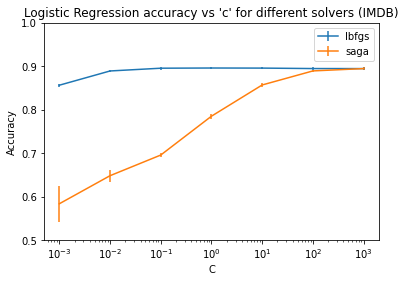

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
print(mean_accs)
print(std_accs)

plt.errorbar(c_list,mean_accs[0],std_accs[0],label='lbfgs')
plt.errorbar(c_list,mean_accs[1],std_accs[1],label='saga')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.title('Logistic Regression accuracy vs \'c\' for different solvers (IMDB)')
plt.legend()
plt.ylim([0.5, 1])
plt.savefig('logreg_hyper.png')
#files.download('logreg_hyper.png') 

Here we construct a confusion matrix and calculate recall and precision

In [12]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

logistic_reg = LogisticRegression(C=1,max_iter=1000)
logistic_reg.fit(x_train,y_train)
yhat = logistic_reg.predict(x_test)
acc_test = accuracy_score(y_test,yhat)
print(acc_test)

c_mat = confusion_matrix(y_test, yhat)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
print(c_mat)
print('Precision is: ',precision)
print('Recall is: ',recall)

0.8696
[[10883.  1617.]
 [ 1643. 10857.]]
Precision is:  0.87064
Recall is:  0.8688328277183458


Since I'm lazy I'm using sklearn's plot confusion matrix rather than using the numbers I created but they're in agreement

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

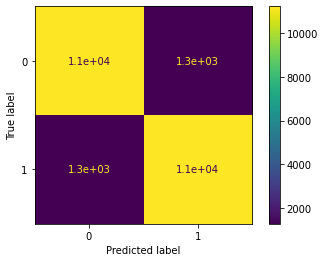

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from google.colab import files

disp = plot_confusion_matrix(logistic_reg,x_test_freq,y_test)
#disp.plot()
plt.savefig('confusion_mat_imdb.png')
files.download('confusion_mat_imdb.png') 

Graph that shows accuracy vs training set size

No handles with labels found to put in legend.


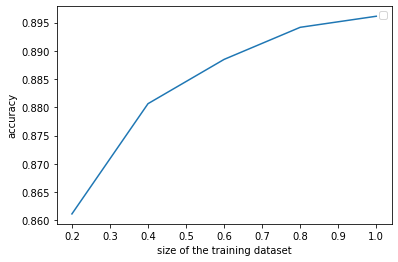

In [8]:
# Split the training set into different sizes
def size_split(x_train, y_train, n_test_list):
  x_train_sizes_list = []
  y_train_sizes_list = []
  for n in n_test_list:
    num_instances = x_train.shape[0]
    inds = np.random.permutation(num_instances)
    n_test = int(num_instances*n) - 1
    
    #shuffle the data
    x_train_sizes = x_train.tocsr()[inds,]
    y_train_sizes = y_train[inds]

    #store data
    x_train_sizes = x_train_sizes[:n_test,:]
    x_train_sizes_list.append(x_train_sizes)

    y_train_sizes = y_train_sizes[:n_test]
    y_train_sizes_list.append(y_train_sizes)

  return x_train_sizes_list, y_train_sizes_list


n_sizes = [0.2, 0.4, 0.6, 0.8, 1]
x_train_sizes_list, y_train_sizes_list = size_split(x_train_freq, y_train, n_test_list=n_sizes)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

err_test = []

for i in range(len(x_train_sizes_list)):

    logistic_reg = LogisticRegression(C=1, max_iter = 1000)
    logistic_reg.fit(x_train_sizes_list[i], y_train_sizes_list[i])
    err_test.append(accuracy_score(y_test, logistic_reg.predict(x_test_freq)))


Plotting the last section

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

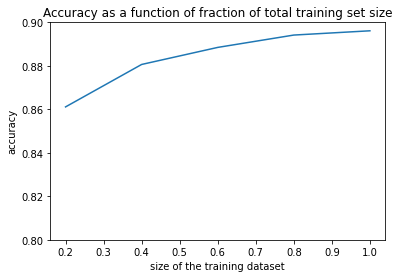

In [13]:
from google.colab import files
plt.plot(n_sizes, err_test, '-')
#plt.legend()
plt.xlabel('size of the training dataset')
plt.ylabel('accuracy')
plt.title('Accuracy as a function of fraction of total training set size')
plt.ylim([0.8, 0.9])
plt.savefig('accvssize_imdb.png')
files.download('accvssize_imdb.png') 
plt.show()

Also ran GridSearchCV as a sanity check with different hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_search.fit(train_set[0] , y_cv_train['fold_'+str(0)])
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=0.001, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.501, total=   0.4s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.501, total=   0.4s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.501, total=   0.3s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.501, total=   0.4s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.501, total=   0.4s
[CV] C=0.001, max_iter=100, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=sag, score=nan, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


KeyboardInterrupt: ignored